### 1.Dataset e Objetivo
O dataset usado nesse projeto, contém tweets e uma classificação referente aos autores de sacarsmo ou ironia. Com base no paper: <br/>https://link.springer.com/chapter/10.1007/978-3-319-47602-5_39 <br/>
Iremos trabalhar a idea central que é dado um twetter, qual a natureza dele, sacarsmo? ironia? ou ambos.


Colunas: <br/>
`tweets` : texto do tweet <br/>
`class` : figurative - irony - regular - sarcasm <br/>


O objetivo principal do estudo é analisar, de forma quantitativa, a diferença entre sarcasmo e ironia, com foco em como essas formas de linguagem figurativa são utilizadas por autores no Twitter. O trabalho busca entender se é possível distinguir automaticamente essas duas formas de expressão e quais características são mais relevantes para essa distinção.

In [1]:
# loader dataset
import pandas as pd

df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")
df_all = pd.concat([df_train, df_test], sort=False)

# sample data
sample_data = df_all.sample(33000)


In [2]:
# describe data
sample_data.describe().T

,count,unique,top,freq
tweets,33000,30815,$$$=&gt;&gt; #peace #love #freedom\n#fight for...,6
class,32997,4,figurative,8593


In [3]:
# Ver o balanceamento do sample_data
class_balance = sample_data['class'].value_counts()
print(class_balance)

class
figurative    8593
irony         8583
sarcasm       8269
regular       7552
Name: count, dtype: int64


In [4]:
#Head
sample_data.head()

,tweets,class
13734,I shouldnt be here #ironic http://t.co/5ypad9XFpf,figurative
24623,"wow-argument, since Hinduism can respect other...",irony
1681,@chrisgb00 @chastings1049 @KevinDunn01 @courte...,figurative
55043,Who's going to break #Reagan 's 11th commandme...,regular
49257,ESPN Football UK: Premier League sets new spen...,regular


## Definir um Pipeline de Classificação
#### Pré-processamento:
- Tokenização: Dividir os tweets em palavras individuais.
- Conversão para Minúsculas: Normalizar o texto convertendo tudo para minúsculas.
- Remoção de Stopwords: Remover stopwords comuns como "the", "is", etc.
- Lematização/Radicalização: Reduzir as palavras à sua forma base (por exemplo, "running" → "run").
- Tratamento de Caracteres Especiais: Manter caracteres especiais importantes, como emoticons, e remover URLs e menções (@username).
#### Feature Engineering:
- Bag of Words (BoW): Converter o texto em um vetor de ocorrências de palavras.
- TF-IDF: Ajustar o modelo BoW considerando a importância de uma palavra em relação à sua frequência em todos os tweets.
- Features de Sentimento: Usar lexicons de sentimento para atribuir escores de sentimento a cada tweet (positivo ou negativo).
- Contagem de Emoticons: Rastrear o número de emoticons em cada tweet, pois eles muitas vezes transmitem sentimento adicional.
#### Modelos:
- Logistic Regression: Um modelo simples e interpretável adequado para classificação binária.
- Random Forest: Um método robusto de ensemble que combina várias árvores de decisão.
- Support Vector Machine (SVM): Conhecido por sua eficácia em classificação de texto.


Assumptions do Modelo Bag-of-Words: Para a classificação sarcasmo/ironia, BoW faz sentido porque a presença de palavras específicas (como "yay" em tweets sarcásticos) pode indicar fortemente a categoria do tweet. No entanto, essa abordagem pode falhar em casos onde o sarcasmo é implícito e depende da combinação de palavras em vez de ocorrências individuais de palavras.

In [18]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem import WordNetLemmatizer

# nltk.download('stopwords')
# nltk.download('wordnet')

data = sample_data 
data = data.dropna()
# Lowercasing
data.loc[:, 'tweets'] = data['tweets'].str.lower()

# Remover stopwords
stop_words = set(stopwords.words('english'))
data.loc[:, 'tweets'] = data['tweets'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Lemmatização
lemmatizer = WordNetLemmatizer()
data.loc[:, 'tweets'] = data['tweets'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(data['tweets'], data['class'], test_size=0.2, random_state=42)

# Vetorização (Bag of Words)
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)

# Transformar em TF-IDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)


### Treinamento do Modelo:
- Treinar os modelos de regressão logística, random forest e SVM no dataset pré-processado.
- Avaliar o desempenho usando o balanced accuracy score, já que as classes podem não estar perfeitamente balanceadas.
### Identificar Features Importantes:
- Usar os coeficientes da regressão logística ou a importância das features no random forest para identificar as palavras mais impactantes na classificação.
### Avaliação:
Discutir quais palavras são proeminentes na classificação (por exemplo, sarcasmo geralmente inclui palavras como "yay", "awesome", enquanto a ironia usa palavras mais descritivas como "however").

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import balanced_accuracy_score

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)

X_test_counts = vectorizer.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
y_pred_lr = lr.predict(X_test_tfidf)
print(f"Logistic Regression - Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_lr)}")

# Random Forest
rf = RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1) 
rf.fit(X_train_tfidf, y_train)
y_pred_rf = rf.predict(X_test_tfidf)
print(f"Random Forest - Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_rf)}")

# Support Vector Machine
svc = LinearSVC(max_iter=1000)
svc.fit(X_train_tfidf, y_train)
y_pred_svc = svc.predict(X_test_tfidf)
print(f"SVM - Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_svc)}")


Logistic Regression - Balanced Accuracy: 0.7099991167680213
Random Forest - Balanced Accuracy: 0.67611842963255
SVM - Balanced Accuracy: 0.6613845917550152


# 4. Avaliar o Tamanho do Dataset
Para avaliar o impacto do tamanho do dataset, execute o modelo várias vezes em diferentes subconjuntos (por exemplo, 10%, 30%, 50% e 100% dos dados). Plote as taxas de erro de treino e teste para determinar se o desempenho do modelo melhora com mais dados ou atinge um platô.

Se o desempenho aumentar significativamente com mais dados, isso sugere espaço para melhoria ampliando o dataset. No entanto, coletar mais tweets sarcásticos e irônicos pode ser difícil e custoso em um cenário de negócios real.

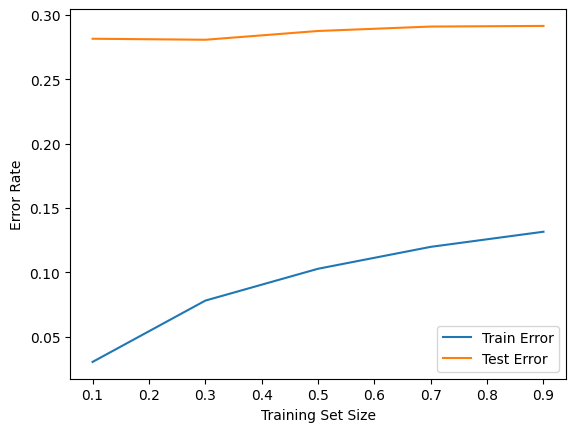

In [20]:
import matplotlib.pyplot as plt
import numpy as np

train_sizes = [0.1, 0.3, 0.5, 0.7, 0.9]  
train_errors = []
test_errors = []

for size in train_sizes:
    X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, train_size=size, random_state=42)
    X_train_sub_counts = vectorizer.transform(X_train_sub)
    X_train_sub_tfidf = tfidf_transformer.transform(X_train_sub_counts)
    
    # Treinar o modelo Logistic Regression em subconjuntos
    lr.fit(X_train_sub_tfidf, y_train_sub)
    y_train_pred = lr.predict(X_train_sub_tfidf)
    y_test_pred = lr.predict(X_test_tfidf)
    
    # Calcular erro no treino e no teste
    train_errors.append(1 - balanced_accuracy_score(y_train_sub, y_train_pred))
    test_errors.append(1 - balanced_accuracy_score(y_test, y_test_pred))

# Plotar
plt.plot(train_sizes, train_errors, label='Train Error')
plt.plot(train_sizes, test_errors, label='Test Error')
plt.xlabel('Training Set Size')
plt.ylabel('Error Rate')
plt.legend()
plt.show()


Train Error (linha azul): <br/>À medida que o tamanho do conjunto de treino aumenta, o erro no conjunto de treino também aumenta. Isso faz sentido, pois quanto mais dados usamos no treino, mais difícil se torna para o modelo "memorizar" os dados, levando a um aumento no erro de treino.

Test Error (linha laranja):<br/> A taxa de erro no conjunto de teste permanece relativamente estável e alta, mostrando que o modelo está com dificuldades para generalizar bem, independentemente do aumento do conjunto de treino.


Este comportamento sugere que o modelo pode estar sofrendo de underfitting, ou seja, ele não está conseguindo capturar adequadamente a complexidade dos dados, pois o erro de teste não melhora com mais dados de treino e o erro de treino aumenta gradualmente. O aumento do tamanho do conjunto de dados de treino não está resultando em melhorias significativas no desempenho no conjunto de teste, sugerindo que outras técnicas, como o ajuste do modelo ou o uso de diferentes abordagens, poderiam ser exploradas para melhorar a performance.

# 5. Modelos de Tópicos e Classificação em Dois Níveis
### LDA (Latent Dirichlet Allocation):
- Aplicar LDA para identificar tópicos dominantes dentro dos tweets.
- Atribuir cada tweet ao seu tópico mais provável e observar se certos tópicos (por exemplo, política, esportes) têm uma taxa de erro de classificação maior ou menor.
### Classificação em Duas Camadas:
- Usar o modelo de tópicos para primeiro atribuir um rótulo de tópico a cada tweet.
- Treinar classificadores separados para cada tópico e comparar o desempenho com o classificador de uma camada.
- Isso pode melhorar o desempenho se certos tópicos (como sarcasmo político) forem mais fáceis de classificar do que outros.

In [9]:
from sklearn.decomposition import LatentDirichletAllocation

# Aplicar LDA para identificar tópicos
lda = LatentDirichletAllocation(n_components=5, random_state=42)
X_train_topics = lda.fit_transform(X_train_tfidf)

# Mostrar os tópicos
terms = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx}:")
    print([terms[i] for i in topic.argsort()[:-11:-1]])


Topic 0:
['co', 'sarcasm', 'http', 'irony', 'https', 'ironic', 'education', 'love', 'people', 'know']
Topic 1:
['irony', 'co', 'sarcasm', 'http', 'ironic', 'https', 'love', 'sarcastic', 'people', 'make']
Topic 2:
['sarcasm', 'co', 'irony', 'http', 'ironic', 'https', 'good', 'news', 'day', 'like']
Topic 3:
['sarcasm', 'co', 'http', 'irony', 'https', 'ironic', 'late', 'love', 'funny', 'great']
Topic 4:
['co', 'http', 'irony', 'sarcasm', 'ironic', 'https', 'politics', 'amp', 'peace', 'late']


### Topic 0:

Principais termos: ['co', 'sarcasm', 'http', 'irony', 'https', 'ironic', 'education', 'love', 'people', 'know']
Esse tópico parece estar relacionado à educação e às interações sociais, com termos como "education", "love", "people", mas também inclui muitas palavras associadas ao sarcasmo e ironia.
### Topic 1:

Principais termos: ['irony', 'co', 'sarcasm', 'http', 'ironic', 'https', 'love', 'sarcastic', 'people', 'make']
Esse tópico parece estar fortemente relacionado a ironia e sarcasmo, com palavras como "irony", "sarcasm", e "sarcastic", o que faz sentido dado o propósito do conjunto de dados.
### Topic 2:

Principais termos: ['sarcasm', 'co', 'irony', 'http', 'ironic', 'https', 'good', 'news', 'day', 'like']
O tópico pode estar relacionado a notícias ou eventos diários, com termos como "good", "news", "day", indicando a presença de tweets sarcásticos ou irônicos sobre o dia-a-dia.
### Topic 3:

Principais termos: ['sarcasm', 'co', 'http', 'irony', 'https', 'ironic', 'late', 'love', 'funny', 'great']
Esse tópico parece incluir tweets que usam sarcasmo para comentar situações como estar atrasado ("late") ou fazer observações engraçadas ("funny").
### Topic 4:

Principais termos: ['co', 'http', 'irony', 'sarcasm', 'ironic', 'https', 'politics', 'amp', 'peace', 'late']
Este tópico parece estar relacionado a política, paz e sarcasmo/ironia, com termos como "politics", "peace", sugerindo que esses temas aparecem frequentemente nas discussões irônicas ou sarcásticas.
### Observações:
Muitos termos como ['co', 'http', 'https'] são comuns em todos os tópicos e não ajudam a distinguir os temas. Estes termos provavelmente estão relacionados a links ou URLs nos tweets.


Os tópicos indicam que os tweets estão frequentemente relacionados a sarcasmo, ironia e sentimentos em contextos como política, notícias, educação e interações sociais.
Isso pode ser útil para análise e interpretação de sarcasmo ou ironia em contextos específicos dentro das redes sociais.

### Classificação em Dois Níveis:
Primeiro, categorizamos os tweets em tópicos e depois treinamos classificadores para cada tópico.

In [11]:
from sklearn.model_selection import StratifiedKFold

# Dividir por tópicos (camada 1)
topic_labels = np.argmax(X_train_topics, axis=1)

# Classificar cada tópico separadamente
for topic in np.unique(topic_labels):
    print(f"Training classifier for topic {topic}")
    topic_idx = (topic_labels == topic)
    
    # Treinar classificador apenas para tweets deste tópico
    lr_topic =  LogisticRegression(max_iter=1000)

    lr_topic.fit(X_train_tfidf[topic_idx], y_train[topic_idx])
    
    # Avaliar no conjunto de teste (camada 2)
    test_topic_idx = np.argmax(lda.transform(X_test_tfidf), axis=1) == topic
    y_pred_topic = lr_topic.predict(X_test_tfidf[test_topic_idx])
    print(f"Balanced Accuracy for topic {topic}: {balanced_accuracy_score(y_test[test_topic_idx], y_pred_topic)}")


Training classifier for topic 0
Balanced Accuracy for topic 0: 0.6996646752758852
Training classifier for topic 1
Balanced Accuracy for topic 1: 0.7069464559317395
Training classifier for topic 2
Balanced Accuracy for topic 2: 0.6944046274715068
Training classifier for topic 3
Balanced Accuracy for topic 3: 0.6944809612401913
Training classifier for topic 4
Balanced Accuracy for topic 4: 0.6654482089665951


### Divisão por Tópicos:

- O modelo LDA foi aplicado para identificar cinco tópicos latentes nos tweets de treinamento.
- Para cada tweet, o tópico mais provável é selecionado como rótulo (utilizando np.argmax).
### Treinamento de Classificadores Separados:

- Para cada um dos cinco tópicos, o código treina um classificador de regressão logística (Logistic Regression) apenas nos tweets pertencentes a esse tópico.
- Isso significa que a classificação de sarcasmo/ironia é realizada separadamente para cada tópico, potencialmente capturando nuances específicas de sarcasmo ou ironia em cada contexto.
### Avaliação de Cada Tópico:

- Para o conjunto de testes, o modelo LDA é novamente utilizado para identificar a qual tópico cada tweet pertence.
- A regressão logística treinada para o respectivo tópico faz a predição, e o desempenho é avaliado utilizando o balanced accuracy score (acurácia balanceada).

Este modelo primeiro usa LDA para agrupar os tweets em tópicos e, em seguida, treina classificadores separados para cada grupo de tópicos, avaliando seu desempenho no conjunto de testes.